In [1]:
from rdkit import Chem
from rdkit.Chem import Descriptors

import numpy as np
import pandas as pd
import math

from mordred import Calculator, descriptors

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import seaborn as sb

from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import root_mean_squared_error,r2_score,mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso

from tqdm import tqdm

random_seed = 4568

# Calculate all descriptors

In [2]:
calc = Calculator(descriptors, ignore_3D=True)

In [3]:
len(calc.descriptors)

1613

In [4]:
df = pd.read_csv('../data/crc.csv', sep=';', usecols=['IUPAC_name', 'SMILES', 'InChIKey', 'boiling_point'])
df['Mol'] = df.SMILES.apply(Chem.MolFromSmiles)

In [5]:
df.head()

,boiling_point,SMILES,IUPAC_name,InChIKey,Mol
0,-0.5,CCCC,butane,IJDNQMDRQITEOD-UHFFFAOYSA-N,<rdkit.Chem.rdchem.Mol object at 0x000001CA524...
1,216.3,CCCCCCCCCCCC,dodecane,SNRUBQQJIBEYMU-UHFFFAOYSA-N,<rdkit.Chem.rdchem.Mol object at 0x000001CA524...
2,-42.1,CCC,propane,ATUOYWHBWRKTHZ-UHFFFAOYSA-N,<rdkit.Chem.rdchem.Mol object at 0x000001CA524...
3,-88.6,CC,ethane,OTMSDBZUPAUEDD-UHFFFAOYSA-N,<rdkit.Chem.rdchem.Mol object at 0x000001CA524...
4,244.0,CCCCCCCCCCCCCCCCCC(CCCC)CCCC,5-butyldocosane,CSRNPDQIQWQJCM-UHFFFAOYSA-N,<rdkit.Chem.rdchem.Mol object at 0x000001CA524...


In [6]:
def calculate_descriptors(mol):
    desc_values = calc(mol)
    desc_dict = {}
    
    for d, v in desc_values.items():
        try:
            value = float(v)
            # Check for NaN or infinity (overflow issues)
            if np.isfinite(value):
                desc_dict[str(d)] = value
            else: # Replace with NaN
                desc_dict[str(d)] = np.nan
                
        # Replace errors with NaN
        except (ValueError, OverflowError, TypeError):
            desc_dict[str(d)] = np.nan
    
    return desc_dict

In [7]:
df_desc = df['Mol'].apply(calculate_descriptors).apply(pd.Series)

c:\Users\barca\miniconda3\envs\BP\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [8]:
df_desc.head(3)

,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,NaN,NaN,0.0,0.0,4.472136,1.618034,3.236068,4.472136,1.118034,2.155909,...,5.509388,22.328143,58.078250,4.148446,10.0,1.0,10.0,8.0,2.50,1.25
1,NaN,NaN,0.0,0.0,14.592460,1.941884,3.883767,14.592460,1.216038,3.291100,...,7.720018,38.766486,170.203451,4.479038,286.0,9.0,42.0,40.0,4.50,3.25
2,NaN,NaN,0.0,0.0,2.828427,1.414214,2.828427,2.828427,0.942809,1.849457,...,4.174387,17.310771,44.062600,4.005691,4.0,0.0,6.0,4.0,2.25,1.00


In [9]:
# Remove columns where all rows are NaN values
nan_columns = df_desc.columns[df_desc.isna().all()].tolist()
print('Number of NaN columns: ', len(nan_columns))
df_desc = df_desc.drop(columns=nan_columns)
print(nan_columns)

Number of NaN columns:  175
['ABC', 'ABCGG', 'SpAbs_Dt', 'SpMax_Dt', 'SpDiam_Dt', 'SpAD_Dt', 'SpMAD_Dt', 'LogEE_Dt', 'SM1_Dt', 'VE1_Dt', 'VE2_Dt', 'VE3_Dt', 'VR1_Dt', 'VR2_Dt', 'VR3_Dt', 'DetourIndex', 'MAXsLi', 'MAXssBe', 'MAXssssBe', 'MAXssBH', 'MAXsssB', 'MAXssssB', 'MAXdCH2', 'MAXtCH', 'MAXdsCH', 'MAXaaCH', 'MAXddC', 'MAXtsC', 'MAXdssC', 'MAXaasC', 'MAXaaaC', 'MAXsNH3', 'MAXsNH2', 'MAXssNH2', 'MAXdNH', 'MAXssNH', 'MAXaaNH', 'MAXtN', 'MAXsssNH', 'MAXdsN', 'MAXaaN', 'MAXsssN', 'MAXddsN', 'MAXaasN', 'MAXssssN', 'MAXsOH', 'MAXdO', 'MAXssO', 'MAXaaO', 'MAXsF', 'MAXsSiH3', 'MAXssSiH2', 'MAXsssSiH', 'MAXssssSi', 'MAXsPH2', 'MAXssPH', 'MAXsssP', 'MAXdsssP', 'MAXsssssP', 'MAXsSH', 'MAXdS', 'MAXssS', 'MAXaaS', 'MAXdssS', 'MAXddssS', 'MAXsCl', 'MAXsGeH3', 'MAXssGeH2', 'MAXsssGeH', 'MAXssssGe', 'MAXsAsH2', 'MAXssAsH', 'MAXsssAs', 'MAXsssdAs', 'MAXsssssAs', 'MAXsSeH', 'MAXdSe', 'MAXssSe', 'MAXaaSe', 'MAXdssSe', 'MAXddssSe', 'MAXsBr', 'MAXsSnH3', 'MAXssSnH2', 'MAXsssSnH', 'MAXssssSn', 'MAXsI', '

In [10]:
# Remove descriptors with some NaN values
some_nan_columns = df_desc.columns[df_desc.isna().any()].tolist()
print(len(some_nan_columns))
print(some_nan_columns)
df_desc = df_desc.drop(columns=some_nan_columns)

270
['AATS4dv', 'AATS5dv', 'AATS6dv', 'AATS7dv', 'AATS8dv', 'AATS4d', 'AATS5d', 'AATS6d', 'AATS7d', 'AATS8d', 'AATS4s', 'AATS5s', 'AATS6s', 'AATS7s', 'AATS8s', 'AATS4Z', 'AATS5Z', 'AATS6Z', 'AATS7Z', 'AATS8Z', 'AATS4m', 'AATS5m', 'AATS6m', 'AATS7m', 'AATS8m', 'AATS4v', 'AATS5v', 'AATS6v', 'AATS7v', 'AATS8v', 'AATS4se', 'AATS5se', 'AATS6se', 'AATS7se', 'AATS8se', 'AATS4pe', 'AATS5pe', 'AATS6pe', 'AATS7pe', 'AATS8pe', 'AATS4are', 'AATS5are', 'AATS6are', 'AATS7are', 'AATS8are', 'AATS4p', 'AATS5p', 'AATS6p', 'AATS7p', 'AATS8p', 'AATS4i', 'AATS5i', 'AATS6i', 'AATS7i', 'AATS8i', 'AATSC4c', 'AATSC5c', 'AATSC6c', 'AATSC7c', 'AATSC8c', 'AATSC4dv', 'AATSC5dv', 'AATSC6dv', 'AATSC7dv', 'AATSC8dv', 'AATSC4d', 'AATSC5d', 'AATSC6d', 'AATSC7d', 'AATSC8d', 'AATSC4s', 'AATSC5s', 'AATSC6s', 'AATSC7s', 'AATSC8s', 'AATSC4Z', 'AATSC5Z', 'AATSC6Z', 'AATSC7Z', 'AATSC8Z', 'AATSC4m', 'AATSC5m', 'AATSC6m', 'AATSC7m', 'AATSC8m', 'AATSC4v', 'AATSC5v', 'AATSC6v', 'AATSC7v', 'AATSC8v', 'AATSC4se', 'AATSC5se', 'AATSC

In [11]:
const_cols = [col for col in df_desc.columns if df_desc[col].nunique() == 1]
print(len(const_cols))
print(const_cols)
df_desc = df_desc.drop(columns=const_cols)

405
['nAcid', 'nBase', 'nAromAtom', 'nAromBond', 'nSpiro', 'nBridgehead', 'nHetero', 'nB', 'nN', 'nO', 'nS', 'nP', 'nF', 'nCl', 'nBr', 'nI', 'nX', 'SM1_DzZ', 'SM1_Dzm', 'SM1_Dzv', 'SM1_Dzse', 'SM1_Dzpe', 'SM1_Dzare', 'SM1_Dzp', 'SM1_Dzi', 'nBondsD', 'nBondsT', 'nBondsA', 'nBondsM', 'nBondsKD', 'C1SP1', 'C2SP1', 'C1SP2', 'C2SP2', 'C3SP2', 'HybRatio', 'FCSP3', 'Xch-3d', 'Xch-4d', 'Xch-5d', 'Xch-6d', 'Xch-7d', 'Xch-3dv', 'Xch-4dv', 'Xch-5dv', 'Xch-6dv', 'Xch-7dv', 'NsLi', 'NssBe', 'NssssBe', 'NssBH', 'NsssB', 'NssssB', 'NdCH2', 'NtCH', 'NdsCH', 'NaaCH', 'NddC', 'NtsC', 'NdssC', 'NaasC', 'NaaaC', 'NsNH3', 'NsNH2', 'NssNH2', 'NdNH', 'NssNH', 'NaaNH', 'NtN', 'NsssNH', 'NdsN', 'NaaN', 'NsssN', 'NddsN', 'NaasN', 'NssssN', 'NsOH', 'NdO', 'NssO', 'NaaO', 'NsF', 'NsSiH3', 'NssSiH2', 'NsssSiH', 'NssssSi', 'NsPH2', 'NssPH', 'NsssP', 'NdsssP', 'NsssssP', 'NsSH', 'NdS', 'NssS', 'NaaS', 'NdssS', 'NddssS', 'NsCl', 'NsGeH3', 'NssGeH2', 'NsssGeH', 'NssssGe', 'NsAsH2', 'NssAsH', 'NsssAs', 'NsssdAs', 'Nsss

In [12]:
df = pd.concat([df, df_desc], axis=1)

In [13]:
# df.drop(columns='Mol').to_csv("../data/descriptors_crc.csv", sep=";",index=False)
df = pd.read_csv('../data/descriptors_crc.csv', sep=';')

In [ ]:
df_desc.head(2) 

,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,VE1_A,VE2_A,VE3_A,VR1_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,4.472136,1.618034,3.236068,4.472136,1.118034,2.155909,1.946498,0.486624,-0.250259,5.891993,...,5.509388,22.328143,58.078250,4.148446,10.0,1.0,10.0,8.0,2.5,1.25
1,14.592460,1.941884,3.883767,14.592460,1.216038,3.291100,3.230323,0.269194,1.354904,45.051010,...,7.720018,38.766486,170.203451,4.479038,286.0,9.0,42.0,40.0,4.5,3.25


# Estimate useful descriptors with Lasso

In [15]:
df_lasso = df.drop(columns=['SMILES', 'IUPAC_name', 'InChIKey'])
X = df_lasso.drop(columns=['boiling_point'])
y = df_lasso['boiling_point']

In [16]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=random_seed)

In [18]:
lasso = Lasso(alpha=1, random_state=random_seed)
lasso.fit(X_train, y_train)

Lasso(alpha=1, random_state=4568)

In [19]:
selected_descriptors = X.columns[lasso.coef_ != 0]

In [20]:
selected_descriptors

Index(['SpMAD_A', 'VE1_A', 'VE3_A', 'VR1_A', 'ATSC3s', 'AATSC3s', 'GATS1s',
       'RPCG', 'SsssCH', 'SIC0', 'SIC1', 'BIC1', 'Lipinski', 'PEOE_VSA7',
       'piPC3', 'piPC4', 'piPC6', 'WPath'],
      dtype='object')

# Calculate linear regression for all descriptors

## On unaltered descriptors

In [25]:
df_lr = df.drop(columns=['SMILES', 'IUPAC_name', 'InChIKey'])
X = df_lr.drop(columns=['boiling_point'])
y = df_lr['boiling_point']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_seed)

In [22]:
def evaluate_descriptor(descriptor):
    X_train_desc = X_train[[descriptor]]
    X_test_desc = X_test[[descriptor]]
    
    model = LinearRegression()
    model.fit(X_train_desc, y_train)
    
    y_train_pred = model.predict(X_train_desc)
    y_test_pred = model.predict(X_test_desc)
    
    metrics = {
        "descriptor": descriptor,
        "train_MAE": mean_absolute_error(y_train, y_train_pred),
        "test_MAE": mean_absolute_error(y_test, y_test_pred),
        "train_RMSE": root_mean_squared_error(y_train, y_train_pred),
        "test_RMSE": root_mean_squared_error(y_test, y_test_pred),
        "train_R2": r2_score(y_train, y_train_pred),
        "test_R2": r2_score(y_test, y_test_pred)
    }
    
    return metrics

In [27]:
results = [evaluate_descriptor(desc) for desc in tqdm(X_train.columns)]

100%|██████████| 763/763 [00:05<00:00, 148.91it/s]


In [28]:
sorted_results = sorted(results, key=lambda x: x['test_MAE'])

In [29]:
sorted_results[:3]

[{'descriptor': 'VE1_A',
  'train_MAE': 16.44557242928283,
  'test_MAE': 13.197447754485966,
  'train_RMSE': 24.250600720838236,
  'test_RMSE': 17.24594989431946,
  'train_R2': 0.965730268026368,
  'test_R2': 0.9679490172542323},
 {'descriptor': 'VE3_A',
  'train_MAE': 11.621880270001867,
  'test_MAE': 14.282953774060674,
  'train_RMSE': 20.90242999084126,
  'test_RMSE': 28.82652638818768,
  'train_R2': 0.9745399495127831,
  'test_R2': 0.9104528566274863},
 {'descriptor': 'CIC1',
  'train_MAE': 10.361796476040901,
  'test_MAE': 15.321182894284046,
  'train_RMSE': 18.72798888271521,
  'test_RMSE': 33.96850052933904,
  'train_R2': 0.9795615483837661,
  'test_R2': 0.8756574232824755}]

## On log of descriptors

In [32]:
df_lr_log = df.drop(columns=['SMILES', 'IUPAC_name', 'InChIKey']).copy()

In [33]:
cols = df_lr_log.columns[df_lr_log.columns != 'boiling_point']
cols = [col for col in cols if (df_lr_log[col] > 0).all()]

In [34]:
df_lr_log[cols] = np.log(df_lr_log[cols])

In [35]:
# drop columns with and NaN values
df_lr_log = df_lr_log.dropna(axis=1)

In [36]:
df_lr_log.head(2)

,boiling_point,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,VE1_A,VE2_A,VE3_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,-0.5,1.497866,0.481212,1.174359,1.497866,0.111572,0.768212,0.666032,-0.720263,-0.250259,...,1.706454,3.105848,4.061791,1.422734,2.302585,1.0,2.302585,2.079442,0.916291,0.223144
1,216.3,2.680505,0.663658,1.356806,2.680505,0.195598,1.191222,1.172582,-1.312324,1.354904,...,2.043817,3.657556,5.136994,1.499408,5.655992,9.0,3.737670,3.688879,1.504077,1.178655


In [37]:
X = df_lr_log.drop(columns=['boiling_point'])
y = df_lr_log['boiling_point']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_seed)

In [38]:
results_log = [evaluate_descriptor(desc) for desc in tqdm(X_train.columns)]

  0%|          | 0/763 [00:00<?, ?it/s]

100%|██████████| 763/763 [00:05<00:00, 151.60it/s]


In [39]:
sorted_results_log = sorted(results_log, key=lambda x: x['test_MAE'])

In [40]:
sorted_results_log[:3]

[{'descriptor': 'VE1_A',
  'train_MAE': 10.369574406975719,
  'test_MAE': 11.176508823638747,
  'train_RMSE': 15.9799873280265,
  'test_RMSE': 16.26615384058518,
  'train_R2': 0.9851194642807888,
  'test_R2': 0.9714873973881354},
 {'descriptor': 'VE3_A',
  'train_MAE': 11.621880270001867,
  'test_MAE': 14.282953774060674,
  'train_RMSE': 20.90242999084126,
  'test_RMSE': 28.82652638818768,
  'train_R2': 0.9745399495127831,
  'test_R2': 0.9104528566274863},
 {'descriptor': 'SLogP',
  'train_MAE': 10.325899364197666,
  'test_MAE': 14.428585698813812,
  'train_RMSE': 20.13504762055154,
  'test_RMSE': 35.141815038706,
  'train_R2': 0.9763750429491762,
  'test_R2': 0.866919174046388}]

# VE_1A Implementation
It is the sum of absolute values of elements of the eigenvector corresponding to the largest eigenvalue. The vector is normalized.

In [41]:
mol = Chem.MolFromSmiles('CC(C)CC')

In [42]:
am = Chem.rdmolops.GetAdjacencyMatrix(mol)
am

array([[0, 1, 0, 0, 0],
       [1, 0, 1, 1, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 1],
       [0, 0, 0, 1, 0]], dtype=int32)

In [43]:
eigenval, eigenvect = np.linalg.eig(am)
print(eigenval, "_________________", eigenvect, sep='\n')

[-1.84775907e+00  1.84775907e+00 -7.65366865e-01 -1.87234860e-16
  7.65366865e-01]
_________________
[[ 3.53553391e-01  3.53553391e-01 -3.53553391e-01  7.07106781e-01
  -3.53553391e-01]
 [-6.53281482e-01  6.53281482e-01  2.70598050e-01 -5.15704058e-17
  -2.70598050e-01]
 [ 3.53553391e-01  3.53553391e-01 -3.53553391e-01 -7.07106781e-01
  -3.53553391e-01]
 [ 5.00000000e-01  5.00000000e-01  5.00000000e-01  7.59388139e-17
   5.00000000e-01]
 [-2.70598050e-01  2.70598050e-01 -6.53281482e-01 -1.22009389e-16
   6.53281482e-01]]


In [44]:
def calculate_VE1(mol):
    am = Chem.rdmolops.GetAdjacencyMatrix(mol)
    eigenval, eigenvect = np.linalg.eigh(am)
    max_eigenvalue_idx = np.argmax(eigenval)
    corresponding_vector = eigenvect[:, max_eigenvalue_idx]
    ve1 = 0
    for i in corresponding_vector:
        ve1 += abs(i)
    return ve1

In [45]:
calculate_VE1(mol)

2.130986313697834

In [46]:
from mordred import AdjacencyMatrix

In [47]:
calc_ve1 = Calculator(AdjacencyMatrix.AdjacencyMatrix('VE1'))

In [48]:
calc_ve1(mol)

Result(<rdkit.Chem.rdchem.Mol object at 0x000001CA5EE377D0>,[2.130986313697834],[mordred.AdjacencyMatrix.AdjacencyMatrix('VE1')])

In [49]:
df['Mol'] = df.SMILES.apply(Chem.MolFromSmiles)
df['VE1_A_impl'] = df.Mol.apply(calculate_VE1)
df['VE1_A_check'] = round(df['VE1_A'], 9) == round(df['VE1_A_impl'], 9)

In [50]:
df[['VE1_A', 'VE1_A_impl', 'VE1_A_check']].head()

,VE1_A,VE1_A_impl,VE1_A_check
0,1.946498,1.946498,True
1,3.230323,3.230323,True
2,1.707107,1.707107,True
3,1.414214,1.414214,True
4,3.503448,3.503448,True


In [51]:
df.shape[0] - df['VE1_A_check'].sum()

0

# Polynomial fits on unaltered descriptors

In [52]:
df['VE1_A']

0      1.946498
1      3.230323
2      1.707107
3      1.414214
4      3.503448
         ...   
130    2.581377
131    2.618036
132    3.100954
133    2.965687
134    2.823596
Name: VE1_A, Length: 135, dtype: float64

In [53]:
df_lr = df.drop(columns=['SMILES', 'IUPAC_name', 'InChIKey'])
X = df_lr.drop(columns=['boiling_point'])
y = df_lr['boiling_point']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_seed)

In [54]:
X_train_desc = X_train[['VE1_A']]
X_test_desc = X_test[['VE1_A']]

model = LinearRegression()
model.fit(X_train_desc, y_train)

y_train_pred = model.predict(X_train_desc)
y_test_pred = model.predict(X_test_desc)

metrics = {
    "descriptor": 'VE1_A',
    "train_MAE": mean_absolute_error(y_train, y_train_pred),
    "test_MAE": mean_absolute_error(y_test, y_test_pred),
    "train_RMSE": root_mean_squared_error(y_train, y_train_pred),
    "test_RMSE": root_mean_squared_error(y_test, y_test_pred),
    "train_R2": r2_score(y_train, y_train_pred),
    "test_R2": r2_score(y_test, y_test_pred)
}

In [55]:
metrics

{'descriptor': 'VE1_A',
 'train_MAE': 16.44557242928283,
 'test_MAE': 13.197447754485966,
 'train_RMSE': 24.250600720838236,
 'test_RMSE': 17.24594989431946,
 'train_R2': 0.965730268026368,
 'test_R2': 0.9679490172542323}

In [56]:
model.coef_

array([127.92223362])

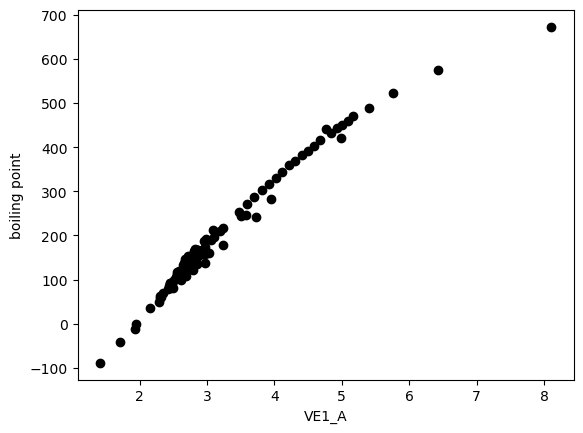

In [57]:
plt.scatter(df.VE1_A, df.boiling_point, color='black', label='W_log', marker='o')
plt.xlabel("VE1_A")
plt.ylabel("boiling point")
plt.show()

In [58]:
degree = 2
poly = PolynomialFeatures(degree=degree)
X_train_poly = poly.fit_transform(X_train_desc)
X_test_poly = poly.transform(X_test_desc)
model_poly = LinearRegression().fit(X_train_poly, y_train)

y_train_pred = model_poly.predict(X_train_poly)
y_test_pred = model_poly.predict(X_test_poly)

metrics = {
        "descriptor": 'VE1',
        "train_MAE": mean_absolute_error(y_train, y_train_pred),
        "test_MAE": mean_absolute_error(y_test, y_test_pred),
        "train_RMSE": root_mean_squared_error(y_train, y_train_pred),
        "test_RMSE": root_mean_squared_error(y_test, y_test_pred),
        "train_R2": r2_score(y_train, y_train_pred),
        "test_R2": r2_score(y_test, y_test_pred)
    }
print(metrics)

{'descriptor': 'VE1', 'train_MAE': 7.895697398289759, 'test_MAE': 9.43924516595272, 'train_RMSE': 10.935781622638341, 'test_RMSE': 13.33281130273483, 'train_R2': 0.9930310818480118, 'test_R2': 0.9808437464930008}


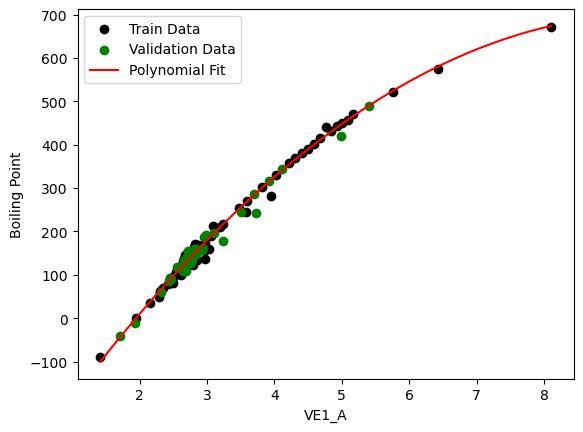

In [59]:
plt.scatter(X_train_desc, y_train, label='Train Data', color='black')
plt.scatter(X_test_desc, y_test, label='Validation Data', color='green')
x_fit = np.linspace(X_train_desc.min().values[0], X_train_desc.max().values[0], 100).reshape(-1, 1)
x_fit_df = pd.DataFrame(x_fit, columns=['VE1_A'])
y_fit = model_poly.predict(poly.transform(x_fit_df))
plt.plot(x_fit, y_fit, color='red', label='Polynomial Fit')
plt.xlabel('VE1_A')
plt.ylabel('Boiling Point')
plt.legend()
plt.show()

In [61]:
def evaluate_descriptor_poly(descriptor, X_train, X_test, y_train, y_test):
    X_train_desc = X_train[[descriptor]]
    X_test_desc = X_test[[descriptor]]

    degree = 2
    poly = PolynomialFeatures(degree=degree)
    X_train_poly = poly.fit_transform(X_train_desc)
    X_test_poly = poly.transform(X_test_desc)
    model_poly = LinearRegression().fit(X_train_poly, y_train)
    
    y_train_pred = model_poly.predict(X_train_poly)
    y_test_pred = model_poly.predict(X_test_poly)
    
    metrics = {
            "descriptor": descriptor,
            "train_MAE": mean_absolute_error(y_train, y_train_pred),
            "test_MAE": mean_absolute_error(y_test, y_test_pred),
            "train_RMSE": root_mean_squared_error(y_train, y_train_pred),
            "test_RMSE": root_mean_squared_error(y_test, y_test_pred),
            "train_R2": r2_score(y_train, y_train_pred),
            "test_R2": r2_score(y_test, y_test_pred)
        }

    return metrics

In [73]:
results = [evaluate_descriptor_poly(desc, X_train, X_test, y_train, y_test) for desc in tqdm(descs)]
sorted_results = sorted(results, key=lambda x: x['test_MAE'])

100%|██████████| 763/763 [00:05<00:00, 140.34it/s]


In [74]:
sorted_results[:3]

[{'descriptor': 'VE1_A',
  'train_MAE': 7.895697398289759,
  'test_MAE': 9.43924516595272,
  'train_RMSE': 10.935781622638341,
  'test_RMSE': 13.33281130273483,
  'train_R2': 0.9930310818480118,
  'test_R2': 0.9808437464930008},
 {'descriptor': 'VE3_A',
  'train_MAE': 10.136728429867127,
  'test_MAE': 11.617272322781348,
  'train_RMSE': 17.035506519371662,
  'test_RMSE': 25.41656213322276,
  'train_R2': 0.9830887461918917,
  'test_R2': 0.9303853370667237},
 {'descriptor': 'VAdjMat',
  'train_MAE': 11.158724531843985,
  'test_MAE': 14.165729803361996,
  'train_RMSE': 20.89824321355608,
  'test_RMSE': 33.983379313305726,
  'train_R2': 0.9745501478376198,
  'test_R2': 0.8755484710774416}]

# Polynomial fits on log of descriptors

In [76]:
df_log = df.drop(columns=['SMILES', 'IUPAC_name', 'InChIKey'])
df_log = df_log.drop(columns=['boiling_point'])
y = df['boiling_point']
cols = [col for col in descs if (df_log[col] > 0).all()]
df_log = df_log[cols]
df_log[cols] = np.log(df_log[cols])
df_log = df_log.dropna(axis=1)
X_train, X_test, y_train, y_test = train_test_split(df_log, y, test_size=0.3, random_state=random_seed)

In [ ]:
results_log = [evaluate_descriptor_poly(desc, X_train, X_test, y_train, y_test) for desc in tqdm(descs)]
sorted_results_log = sorted(results_log, key=lambda x: x['test_MAE'])

100%|██████████| 403/403 [00:02<00:00, 137.46it/s]


In [78]:
sorted_results_log[:5]

[{'descriptor': 'VE1_A',
  'train_MAE': 9.62119109284708,
  'test_MAE': 9.612488343766213,
  'train_RMSE': 13.056993050540541,
  'test_RMSE': 12.900139184377265,
  'train_R2': 0.9900653618950274,
  'test_R2': 0.9820668780181235},
 {'descriptor': 'SLogP',
  'train_MAE': 9.10600303992158,
  'test_MAE': 12.320197591583709,
  'train_RMSE': 19.015040028542835,
  'test_RMSE': 33.95312301117519,
  'train_R2': 0.9789302106601263,
  'test_R2': 0.875769977407826},
 {'descriptor': 'WPath',
  'train_MAE': 9.336567978592644,
  'test_MAE': 12.687844375059601,
  'train_RMSE': 18.12224940191035,
  'test_RMSE': 32.328303504074086,
  'train_R2': 0.9808622925505053,
  'test_R2': 0.8873754834393368},
 {'descriptor': 'ATS3i',
  'train_MAE': 9.358240917846175,
  'test_MAE': 12.75647214451444,
  'train_RMSE': 19.621181827608286,
  'test_RMSE': 33.75251380933222,
  'train_R2': 0.9775655188339452,
  'test_R2': 0.8772336461145904},
 {'descriptor': 'ETA_eta_L',
  'train_MAE': 9.202290109863224,
  'test_MAE': 12.